 # Tensor Prepare

In [6]:
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    RandSpatialCropd,
    Lambdad,
)

TEST_SERIES_COLON = "/Users/joshuabunnell/Projects/data/dicom/ct-colonography_organized/1.3.6.1.4.1.9328.50.4.1/1.3.6.1.4.1.9328.50.4.2"
TEST_SERIES_PED = "/Users/joshuabunnell/Projects/data/dicom/pediatric-ct-seg_organized/1.3.6.1.4.1.14519.5.2.1.52871920226833551870199279497603326842/1.3.6.1.4.1.14519.5.2.1.152462310538135643296361481168522825410"

series_map = {
    "Colonography": TEST_SERIES_COLON,
    "Pediatric": TEST_SERIES_PED,
}

### 1. Define the Pipelines

In [7]:
# PART A: Static Volume Preprocessing (Run once, save to disk)
prep_transforms = Compose(
    [
        LoadImaged(keys=["image"], reader="ITKReader"),
        EnsureChannelFirstd(
            keys=["image"], channel_dim="no_channel"
        ),  # Adds channel -> (1, H, W, D)
        Orientationd(keys=["image"], axcodes="RAS"),  # Geometry: Head-to-Toe
        Spacingd(
            keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"
        ),  # Geometry: 1mm Isotropic
        ScaleIntensityRanged(
            keys=["image"], a_min=-150, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),  # Physics: Soft Tissue Windowing
    ]
)

# PART B: Dynamic Training Transforms (Runs dynamically in PyTorch DataLoader)
train_transforms = Compose(
    [
        RandSpatialCropd(keys=["image"], roi_size=(224, 224, 3), random_size=False),
        # Lambdad formats the tensor for ResNet:
        # x[0] removes the channel dim: (1, 224, 224, 3) -> (224, 224, 3)
        # permute(2,0,1) moves depth to front: (224, 224, 3) -> (3, 224, 224)
        Lambdad(keys=["image"], func=lambda x: x[0].permute(2, 0, 1)),
    ]
)

### 2. Run Static Preprocessing (Simulation of Data Prep Script)

In [8]:
processed_volumes = {}

print("Running Static Preprocessing Pipeline")
for name, path in series_map.items():
    sample = {"image": path}

    # Run the prep pipeline (Returns a DICTIONARY)
    processed_data = prep_transforms(sample)

    # Store the dictionary for the next step
    processed_volumes[name] = processed_data

    # FIXED: Access the tensor using the ["image"] key
    image_tensor = processed_data["image"]

    print(f"[{name}] Final 3D Volume Shape: {image_tensor.shape}")
    print(
        f"[{name}] Value Range -> Min: {image_tensor.min():.2f}, Max: {image_tensor.max():.2f}"
    )

Running Static Preprocessing Pipeline
[Colonography] Final 3D Volume Shape: torch.Size([1, 400, 400, 483])
[Colonography] Value Range -> Min: 0.00, Max: 1.00
[Pediatric] Final 3D Volume Shape: torch.Size([1, 260, 260, 363])
[Pediatric] Value Range -> Min: 0.00, Max: 1.00


### 3. Run Dynamic Cropping (Simulation of PyTorch DataLoader)


In [9]:
final_tensors = {}

print("\nRunning Dynamic Training Pipeline (Cropping)")
for name, processed_data in processed_volumes.items():
    try:
        # Pass the pre-processed dictionary directly into the training pipeline
        cropped_data = train_transforms(processed_data)

        # FIXED: Access the tensor using the ["image"] key
        final_tensor = cropped_data["image"]
        final_tensors[name] = final_tensor

        print(f"[{name}] Tensor Ready for MoCo: {final_tensor.shape}")

    except Exception as e:
        print(f"[{name}] Crop failed. Error: {e}")


Running Dynamic Training Pipeline (Cropping)
[Colonography] Tensor Ready for MoCo: torch.Size([3, 224, 224])
[Pediatric] Tensor Ready for MoCo: torch.Size([3, 224, 224])


### 4. Visualization

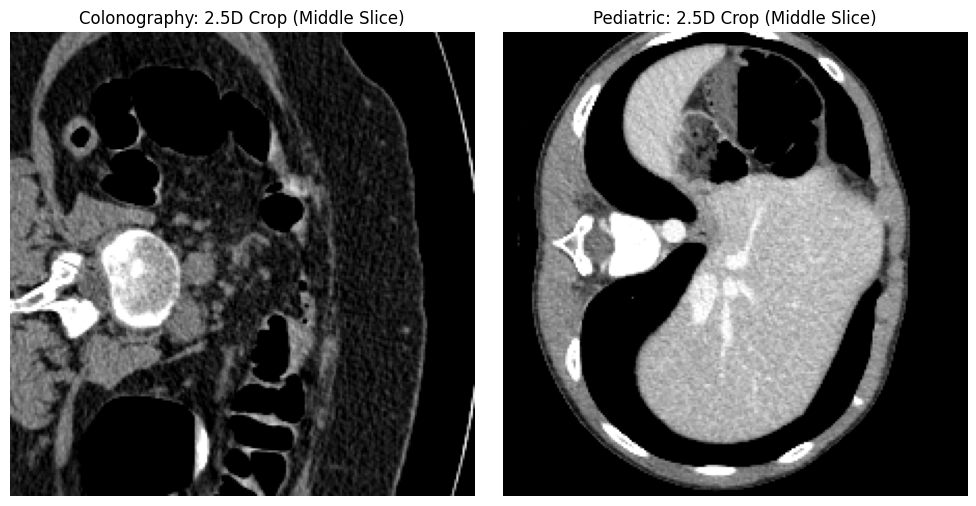

In [10]:
if len(final_tensors) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax, (name, tensor) in zip(axes, final_tensors.items()):
        # Tensor is (3, 224, 224). We want to plot the Middle Slice (index 1).
        # We assume standard 0-1 normalization for display, or just rely on matplotlib scaling
        slice_img = tensor[1, :, :]

        ax.imshow(slice_img, cmap="gray")
        ax.set_title(f"{name}: 2.5D Crop (Middle Slice)")
        ax.axis("off")

    plt.tight_layout()
    plt.show()